In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import mysql.connector
from mysql.connector import Error
import pandas as pd
from mysql.connector import Error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Reshape, Layer, Lambda, Concatenate, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras import backend as be
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta
from keras.layers import BatchNormalization
from keras.regularizers import l2
import matplotlib.pyplot as plt
import LSTM_preprocessing as pre
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
connection = pre.connect_to_database()
if connection:
    # Query merged data
    merged_df = pre.query_merged_crypto_data(connection)
    # converting US bond yield from hourly to yearly under continous compounding assumptions
    merged_df['yield'] = np.exp(merged_df['yield']*365*24)-1

    # Close the connection
    pre.query_quit(connection)

merged_df.head(3)

Connected to MySQL database, MySQL Server version:  8.0.39
MySQL connection is closed


,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,market_cap,coin_supply,yield
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,1294545,None,None,0.008552840317602313182744400
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,936344,None,None,0.008552840317602313182744400
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,724626,None,None,0.008552840317602313182744400


### merging with market cap

In [ ]:
market_caps = pd.read_csv('market_cap_data.csv')
market_caps = market_caps.rename(columns={
    'timestamp': 'date',
    'token': 'crypto_symbol',
})
market_caps.head(3)

,Unnamed: 0,date,market_cap,crypto_symbol
0,0,2020-12-21 00:00:00,87121414,1INCHUSDT
1,1,2020-12-21 01:00:00,87121414,1INCHUSDT
2,2,2020-12-21 02:00:00,87121414,1INCHUSDT


In [24]:
# Convert 'date' columns to pandas datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'])
market_caps['date'] = pd.to_datetime(market_caps['date'])

# Perform the merge based on 'crypto_symbol' and 'date', keeping only rows in merged_df
merged_df.drop('market_cap', axis = 1, inplace=True)
merged_df = pd.merge(
    merged_df,
    market_caps[['date', 'market_cap', 'crypto_symbol']],
    on=['date', 'crypto_symbol'],
    how='left'
)

merged_df.head(3)

,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,coin_supply,yield,market_cap
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,1294545,None,0.008552840317602313182744400,317700843.0
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,936344,None,0.008552840317602313182744400,317700843.0
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,724626,None,0.008552840317602313182744400,317700843.0


In [25]:
# KNC has wrong data before 2021
merged_df = merged_df[merged_df['market_cap'].notna()]
merged_df.reset_index(inplace = True, drop=True)

In [26]:
merged_df_emb = pre.create_llm_embeddings(merged_df, "crypto_symbol", n_components=15)
merged_df_emb = pre.create_cyclical_encodings(merged_df_emb, "date")

In [27]:
# data without NA rows if we needed 
filtered_df = merged_df_emb[(merged_df['borrowing_rate'] != -50)&(merged_df['lending_rate'] != -50)&(merged_df['utilization_rate'] != -50)]
filtered_df['attention'] = filtered_df['volume'] * filtered_df['close']
filtered_df.drop(columns=['stable_borrow_rate','adj_close','coin_supply'], inplace=True)
filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']] = filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']].astype(float)
filtered_df.reset_index(inplace=True, drop=True)

In [28]:
# We scale  market cap, attention, yield together as they are comparable
scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)
filtered_df['yield'] = scaler.fit_transform(filtered_df[['yield']])
filtered_df['market_cap'] = scaler.fit_transform(filtered_df[['market_cap']])
filtered_df['attention'] = scaler.fit_transform(filtered_df[['attention']])

In [29]:
outlier_threshold = "remove"
input_window = 48
output_window = 48
input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate',
                 'close', 'volume', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine']

In [30]:
# Initialize empty lists to store aggregated inputs and targets
X_train,X_valid,X_test = [], [], []
Y_train,Y_valid,Y_test = [], [], []

# looping through symbols
symbols = filtered_df['crypto_symbol'].unique()
for s in symbols:
     try:
          sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
          sim_df.reset_index(inplace=True, drop=True)
          print(s)
          # First Loop: Calculate intervals for each column without modifying the DataFrame
          intervals = {}
          for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
               lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
               intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

          # getting the returns
          reduced_df = sim_df.copy()
          reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
          reduced_df = reduced_df[reduced_df['returns'].notna()]
          reduced_df.reset_index(inplace=True, drop=True)

          # Second Loop: Filter rows based on the pre-calculated intervals
          for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
               lower_bound = intervals[column]['lower_bound']
               upper_bound = intervals[column]['upper_bound']
               # Apply filtering based on pre-calculated bounds
               reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

          reduced_df.reset_index(inplace=True, drop=True)

          # MinMax scaling
          scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

          scaled_df = reduced_df.copy()
          scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
          scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
          scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
          scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
          scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
          scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

          inputs_train, inputs_valid, inputs_test, targets_train, targets_valid, targets_test = pre.extract_valid_windows_v4(
               scaled_df,
               'date', 
               input_window, output_window, 
               input_columns, 
               ['lending_rate','borrowing_rate']
               ,train_end_date="2023-09-01 00:00:00", valid_end_date="2024-03-25 00:00:00")

          # Append results from the current DataFrame

          X_train.append(inputs_train)
          X_valid.append(inputs_valid)
          X_test.append(inputs_test)
          Y_train.append(targets_train)
          Y_valid.append(targets_valid)
          Y_test.append(targets_test)


     except Exception as e:
        # Handle any other exceptions
        print(f"Unexpected error in symbol {s}: {e}")

BATUSDT
LINKUSDT
KNCUSDT
MKRUSDT
MANAUSDT
ZRXUSDT
SNXUSDT
WBTCUSDT
ENJUSDT
RENUSDT
YFIUSDT
UNIUSDT
CRVUSDT
BALUSDT
ENSUSDT
1INCHUSDT


In [31]:
# Concatenate all inputs and targets into single arrays

# Checking for empty blocks of data

X_train = [arr for arr in X_train if len(arr) > 0]
X_valid = [arr for arr in X_valid if len(arr) > 0]
X_test = [arr for arr in X_test if len(arr) > 0]

Y_train = [arr for arr in Y_train if len(arr) > 0]
Y_valid = [arr for arr in Y_valid if len(arr) > 0]
Y_test = [arr for arr in Y_test if len(arr) > 0]

X_train  = np.concatenate(X_train, axis=0) if X_train else np.array([])
X_valid = np.concatenate(X_valid, axis=0) if X_valid else np.array([])
X_test = np.concatenate(X_test, axis=0) if X_test else np.array([])

Y_train  = np.concatenate(Y_train, axis=0) if Y_train else np.array([])
Y_valid = np.concatenate(Y_valid, axis=0) if Y_valid else np.array([])
Y_test  = np.concatenate(Y_test, axis=0) if Y_test else np.array([])

In [32]:
# Lending rate
lending_rate_Y_train = Y_train[:, 0].reshape(Y_train.shape[0], 1) 
lending_rate_Y_valid = Y_valid[:, 0].reshape(Y_valid.shape[0], 1) 
lending_rate_Y_test = Y_test[:, 0].reshape(Y_test.shape[0], 1) 
# Borrowing rate
borrow_rate_Y_train = Y_train[:, 1].reshape(Y_train.shape[0], 1) 
borrow_rate_Y_valid = Y_valid[:, 1].reshape(Y_valid.shape[0], 1) 
borrow_rate_Y_test = Y_test[:, 1].reshape(Y_test.shape[0], 1) 

### Function for getting balanced weights

In [33]:
def balanced_weights(array):
    unique_classes, counts = np.unique(array, return_counts=True)
    row_n = sum(counts)
    weights = [(y/row_n) for y in counts]
    raw_weights = [1.0 / freq for freq in weights]
    normalized_weights = [w / np.mean(raw_weights) for w in raw_weights]
    # Convert to dictionary with class indices as keys
    weights_dict = {i: weight for i, weight in enumerate(normalized_weights)}
    return weights_dict

weights = balanced_weights(borrow_rate_Y_train)
weights_valid = balanced_weights(borrow_rate_Y_valid)
weights_test = balanced_weights(borrow_rate_Y_test)

print(weights)
print(weights_valid)
print(weights_test)

{0: 0.9806359546884784, 1: 0.8250481598399391, 2: 1.1943158854715827}
{0: 0.42067940451794583, 1: 0.8822890045426557, 2: 1.6970315909393985}
{0: 0.45328180414783514, 1: 1.2146149691004369, 2: 1.332103226751728}


### Simulation of Random Guessing based on Training Data Class Distribution

- This is done via bootstrapping to get more accurate results (10000 simulations)

In [34]:
import numpy as np
from sklearn.metrics import f1_score

# Assume Y_test is your true sequential labels
Y_test = borrow_rate_Y_test  # Example sequential data

# Number of bootstrap iterations
num_simulations = 10000

# Get class distribution from Y_test
unique, counts = np.unique(Y_test, return_counts=True)
class_probs = counts / len(Y_test)

# Function to simulate one random guessing sequence
def random_guess_sequence(Y_test, class_probs=weights):
    if class_probs is None:
        # Uniform random guessing
        predictions = np.random.choice([0, 1, 2], size=len(Y_test))
    else:
        # Distribution-based random guessing
        predictions = np.random.choice([0, 1, 2], size=len(Y_test), p=class_probs)
    return predictions

# Simulate random guessing and compute Mean F1 scores
f1_scores = []
for _ in range(num_simulations):
    random_preds = random_guess_sequence(Y_test, class_probs=[0.4146503627901599, 0.32689657830582297, 0.2584530589040172])  # Change `class_probs=None` for uniform
    f1 = f1_score(Y_test, random_preds, average='macro')  # Macro F1 for equal weighting across classes
    f1_scores.append(f1)

# Calculate average and confidence interval of F1 scores
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
conf_interval = (mean_f1 - 1.96 * std_f1 / np.sqrt(num_simulations),
                 mean_f1 + 1.96 * std_f1 / np.sqrt(num_simulations))

# Print results
print(f"Mean F1 Score (Random Guessing): {mean_f1:.4f}")
print(f"95% Confidence Interval: [{conf_interval[0]:.4f}, {conf_interval[1]:.4f}]")


Mean F1 Score (Random Guessing): 0.3236
95% Confidence Interval: [0.3236, 0.3237]


This lets us benchmark whether our model are beating EMH assumptions

### Testing Callback function for Valdidation F1 Score vs Full Epochs

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Reshape, Layer, Lambda, Concatenate, LayerNormalization, MultiHeadAttention, Add, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.optimizers import Adadelta
from keras.layers import BatchNormalization
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import Callback

def Attention_model(X_train,X_valid,X_test,Y_train,Y_valid,Y_test,weights, epochs=30,
                     batch_size=100, d1=0.1, d2 = 0.05, cell_size = 80, attention_heads=4):

    tf.keras.backend.clear_session()
    n_classes = 3

    cell_size_1 = cell_size
    cell_size_2 = cell_size_1//2

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    attention_layer_1 = MultiHeadAttention(
    num_heads=attention_heads,
    key_dim=cell_size)(
    query=inputs,
    key=inputs,
    value=inputs)
    residual_1 = Add()([inputs, attention_layer_1])  # Add residual connection
    norm_1 = LayerNormalization()(residual_1)

    attention_layer_2 = MultiHeadAttention(
    num_heads=attention_heads,
    key_dim=cell_size)(
    query=norm_1,
    key=norm_1,
    value=norm_1)
    residual_2 = Add()([norm_1, attention_layer_2])
    norm_2 = LayerNormalization()(residual_2)
    dropout_1 = Dropout(d1)(norm_2)

    ffw = Dense(cell_size_2, activation="swish", kernel_initializer=HeNormal())(dropout_1)
    dropout_2 = Dropout(d2)(ffw)
    flatten_ = Flatten()(dropout_2)
    ffw_2 = Dense(cell_size_2,activation="swish", kernel_initializer=HeNormal())(flatten_)

    class_predictions = Dense(n_classes, activation='softmax',name="class", kernel_initializer=HeNormal())(ffw_2)
    Attention_base = Model(inputs=inputs, outputs=class_predictions)

    # we will keep this as a standardized learning rate optimizer across all models
    optimizer = Adadelta(
    learning_rate=1.0,
    rho=0.8,
    epsilon=1e-7)      # Default , to prevent division by zero)

    Attention_base.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['f1_score'])

    Attention_base.summary()

    model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_f1_score',
    mode='max',
    save_best_only=True,
    verbose=1)

    history = Attention_base.fit(
    x=X_train, y=Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=epochs,
    batch_size=batch_size,
    class_weight=weights,
    shuffle=False,
    callbacks=[model_checkpoint])


    fig, ax1 = plt.subplots()

    # Plot losses on the primary y-axis
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(history.history['loss'], label='Train Loss', color='red', linestyle='-')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('F1', color='tab:blue')
    ax2.plot(history.history['f1_score'], label='Train F1', color='blue', linestyle='-')
    ax2.plot(history.history['val_f1_score'], label='Validation F1', color='blue', linestyle='--')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Combine legends from both axes
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)  # Legend outside the plot

    plt.title('Model F1 and Loss')
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

    y_pred = Attention_base.predict(X_test)
    y_pred = np.argmax(y_pred, axis=-1)

    return Y_test, y_pred

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 30)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 30)    │     39,390 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 48, 30)    │          0 │ input_layer[0][0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 48, 30)    │         60 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 30)    │     39,390 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 48, 30)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 48, 30)    │         60 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 48, 30)    │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 48, 40)    │      1,240 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 48, 40)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1920)      │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 40)        │     76,840 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class (Dense)       │ (None, 3)         │        123 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 157,103 (613.68 KB)

 Trainable params: 157,103 (613.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 95s 107ms/step - f1_score: 0.4906 - loss: 0.9066 - val_f1_score: 0.2424 - val_loss: 0.9702
Epoch 2/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 89s 106ms/step - f1_score: 0.4806 - loss: 0.8494 - val_f1_score: 0.2696 - val_loss: 0.9518
Epoch 3/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 84s 101ms/step - f1_score: 0.4731 - loss: 0.8332 - val_f1_score: 0.3075 - val_loss: 0.9281
Epoch 4/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 88s 105ms/step - f1_score: 0.4784 - loss: 0.8313 - val_f1_score: 0.3048 - val_loss: 0.9587
Epoch 5/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 82s 98ms/step - f1_score: 0.4743 - loss: 0.8188 - val_f1_score: 0.3404 - val_loss: 0.8898
Epoch 6/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - f1_score: 0.4794 - loss: 0.8173 - val_f1_score: 0.3084 - val_loss: 0.9140
Epoch 7/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 86s 103ms/step - f1_score: 0.4725 - loss: 0.8159 - val_f1_score: 0.3121 - val_loss: 0.9111
Epoch 8/30
838/838 ━━━━━━━━━━━━━━━━━━━━ 88s 105ms/step - f1_score: 0.4712 - loss: 0.8

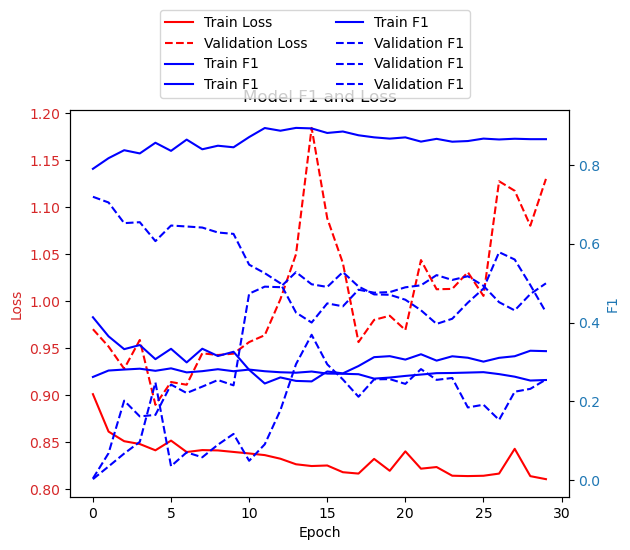

1343/1343 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step


In [73]:
Y_test, y_pred = Attention_model(X_train,X_valid,X_test,borrow_rate_Y_train,borrow_rate_Y_valid,borrow_rate_Y_test,weights)

In [74]:
best_model = tf.keras.models.load_model('best_model.keras')

y_pred_best = best_model.predict(X_test)
y_pred_best = np.argmax(y_pred_best, axis=-1)

1343/1343 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step


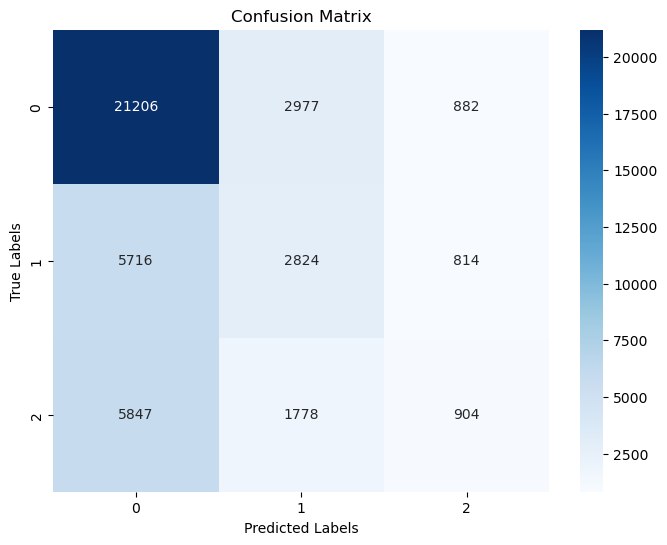

Classification Metrics:
Accuracy: 0.58
Precision: 0.46
Recall: 0.42
F1 Score: 0.41

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.85      0.73     25065
           1       0.37      0.30      0.33      9354
           2       0.35      0.11      0.16      8529

    accuracy                           0.58     42948
   macro avg       0.46      0.42      0.41     42948
weighted avg       0.53      0.58      0.53     42948

(0.5805625407469498, 0.4558122813130509, 0.41797818272653653, 0.4097828548725477)


In [75]:
print(pre.classification_metrics(borrow_rate_Y_test, y_pred_best, printed = True))

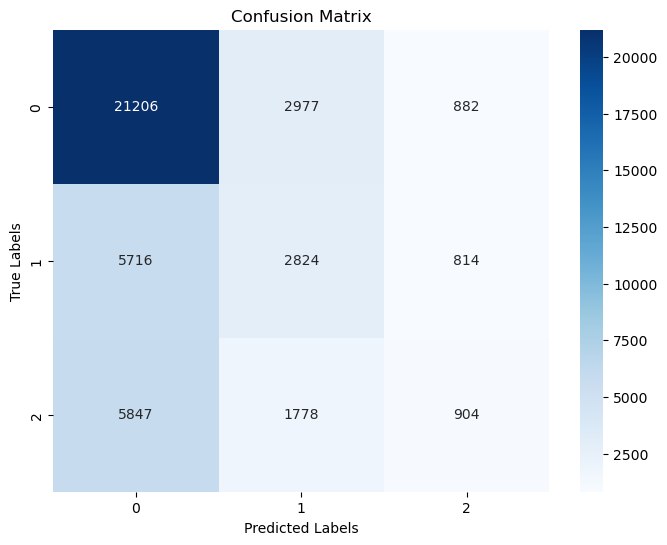

Classification Metrics:
Accuracy: 0.58
Precision: 0.46
Recall: 0.42
F1 Score: 0.41

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.85      0.73     25065
           1       0.37      0.30      0.33      9354
           2       0.35      0.11      0.16      8529

    accuracy                           0.58     42948
   macro avg       0.46      0.42      0.41     42948
weighted avg       0.53      0.58      0.53     42948

(0.5805625407469498, 0.4558122813130509, 0.41797818272653653, 0.4097828548725477)


In [76]:
print(pre.classification_metrics(borrow_rate_Y_test, y_pred, printed = True))

Callback doesn't seem to work for F1 score, we will compare models by running them for 20, 50 and 100 epochs